&nbsp;
&nbsp;
&nbsp;

# **IMPORTACIONES**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping

&nbsp;
&nbsp;
&nbsp;

# **DATASET DE ENTRENAMIENTO**

### Carga del dataset de entrenamiento

In [ ]:
mainpath_train = '../input/landmark-recognition-2021/train'
traindf = pd.read_csv('../input/landmark-recognition-2021/train.csv')

#Añadir a train.csv la columna con la dirección de cada imagen para su posterior lectura
traindf['img_path'] = traindf['id'].apply(lambda r: os.path.join(mainpath_train, r[0], r[1], r[2], r + '.jpg'))

landmark_unique = traindf['landmark_id'].unique()    #Clases totales del dataset (monumentos diferentes)
n_landmark = len(landmark_unique)                    #Es el número de neuronas de la última capa de la red neuronal convolucional

traindf.head()

### Información numérica del dataset de entrenamiento

In [ ]:
print('Datos del dataset de entrenamiento \n')
print('Número de imágenes en el dataset a clasificar: ', traindf.shape[0])
print('Número de monumentos (clases) diferentes: ', n_landmark)
print('Repeticiones de elementos por clase: Mínimo', min(traindf['landmark_id'].value_counts()),
      'y Máximo',max(traindf['landmark_id'].value_counts()))

### Contenido del dataset de entrenamiento: primeras imágenes

In [ ]:
# Mostrar los primeros monumentos del dataset

tam = 256

plt.figure(figsize=(25,7))

for i in range(12):
    random_img = plt.imread(traindf['img_path'][i])
    random_img = cv2.resize(random_img,(tam,tam))      #Para que tengan el mismo tamaño (= número de píxeles = neuronas de entrada)
    plt.subplot(2 , 6, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Clase: '+ str(traindf['landmark_id'][i]))
    plt.imshow(random_img)
    
plt.show()

### Contenido del dataset de entrenamiento: imágenes aleatorias

In [ ]:
# Mostrar algunos monumentos aleatorios del dataset

plt.figure(figsize=(25,7))

for i in range(12):
    random_row = np.random.randint(0, traindf.shape[0])
    random_img = plt.imread(traindf['img_path'][random_row])
    random_img = cv2.resize(random_img,(tam,tam))
    plt.subplot(2 , 6, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Clase: '+ str(traindf['landmark_id'][random_row]))
    plt.imshow(random_img)
    
plt.show()

### Selección de la cantidad de datos a emplear del dataset de entrenamiento

In [ ]:
#Muestra del dataframe original (para agilizar las pruebas)

N_DATOS = 1000

traindf_s = traindf.iloc[:N_DATOS,:]

#unique_classes = len(traindf_s['landmark_id'].unique())          #Número de monumentos distintos dentro de la muestra que se empleará

traindf = None     #Eliminar el dataframe que no se usará más para liberar memoria

traindf_s

### Redimensionamiento de las imágenes del dataset de entrenamiento. Almacenamiento de las imágenes en una variable y de las etiquetas en otra

In [ ]:
IMG_SIZE = 256

datos_entrenamiento = []

def img_resize(img_path):             #Función para redimensionar las imágenes
    img = plt.imread(img_path)
    img_redim = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    return img_redim

#X = []   #Imágenes
#y = []   #Clases
datos_entrenamiento=[]

for i in range(traindf_s.shape[0]):                        #Relleno de una lista con imágenes redimensionadas y otra con sus clases
    redim = img_resize(traindf_s['img_path'][i])
    aux = np.array(traindf_s['landmark_id'][i])
    #X.append(img_resize(traindf_s['img_path'][i])) 
    #y.append(np.array(traindf_s['landmark_id'][i]))      #Cada etiqueta se convierte en numpy.ndarray (por compatibilidad con las imágenes en X, que son ndarrays)
    datos_entrenamiento.append([redim,tf.convert_to_tensor(aux, dtype=tf.int64, dtype_hint=None, name=None)])    #Tensor
        
#df_train = pd.DataFrame(datos_entrenamiento, columns = ['img','landmark_id'])        #Convertimos lista a pd.DataFrame
                          
#print('X: ', type(X))
#print('Elementos de X: ', type(X[0]))
#print('\ny: ', type(y))
#print('Elementos de y: ', type(y[0]))

In [ ]:
datos_entrenamiento[0]

In [ ]:
#Conversión de lista a array necesaria

X=[]
y=[]

for img,clase in datos_entrenamiento:
    X.append(img)
    y.append(clase)

print('X: ', type(X))
print('Elementos de X: ', type(X[0]))
print('\ny: ', type(y))
print('Elementos de y: ', type(y[0]))

### Normalización de las imágenes (Comprobado: aumenta la velocidad del programa x6)

In [ ]:
X = np.array(X).astype(float)/255       #Normalizamos las imágenes para que los píxeles estén entre [0,1] en vez de [0,255] --------> Mayor velocidad de ejecución
X.shape

In [ ]:
X[0]

In [ ]:
y=np.array(y)
y

### Obtención de los datos de validación a partir del dataset de entrenamiento

In [ ]:
#Separación de los datos en datos para entrenamiento y datos para validación

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state=0)  #Mismo tipo que X e y (ndarray formado por ndarrays o int64, respectivamente)

print('Imágenes en X: ',len(X), ' y etiquetas en y: ', len(y))
print('Entrenamiento. Imágenes en X_train: ',len(X_train), 'y etiquetas en y_train: ',len(y_train))
print('Validación. Imágenes en X_val: ',len(X_val), 'y etiquetas en y_val: ',len(y_val))

&nbsp;
&nbsp;
&nbsp;

# **DATASET DE TESTEO**

### Carga del dataset de testeo

'''
mainpath_test = '../input/landmark-recognition-2021/test'

ds_test = image_dataset_from_directory(
    mainpath_test,
    labels=None,       #Puesto que las etiquetas son desconocidas (para confirmar el acierto de la predicción se imprimirá otra imagen de la clase supuesta)
    label_mode='int',              #Porque se utilizará la función de pérdida loss='sparse_categorical_crossentropy'
    image_size=[IMG_SIZE, IMG_SIZE],      #Redimensionamiento al mismo tamaño que las imágenes de entrenamiento
    interpolation='bilinear',
    batch_size=1,
    shuffle=True,      #Para que salgan en orden aleatorio
)
'''

'''
def convert_to_int(image):
    image = tf.image.convert_image_dtype(image, dtype=tf.int64)
    return image

ds_test.map()
type(ds_test)
'''

&nbsp;
&nbsp;
&nbsp;

# **HIPERPARÁMETROS DEL MODELO**

In [ ]:
#Parámetros de la red neuronal convolucional

kernelSize = (3,3)            #Tamaño de la plantilla de convolución
paddingType = 'same'          #Cómo se procede en los bordes de las imágenes ('same' o 'valid')
activationF = 'relu'          #Función de activación
poolSize = (2,2)              #Tamaño de la plantilla de maximum pooling
stridesSize = (2,2)           #Desplazamiento de plantilla durante maximum pooling
dropoutRate = 0.5             #Porcentaje de neuronas que se desactivan con la capa Dropout
#batchSize (tomará valores en un bucle)   #Cantidad de datos con los que se entrena en cada época (tomará valores en un bucle)
epochsSize= 100                 #Número de épocas en las que se entrena

&nbsp;
&nbsp;
&nbsp;

# **FUNCIÓN PARA CREACIÓN, COMPILACIÓN Y ENTRENAMIENTO DEL MODELO**

In [ ]:
def crear_modelo(kernelSize, paddingType, activationF, IMG_SIZE, poolSize, stridesSize, dropoutRate, X_train, y_train, X_val, y_val, batchSize, epochsSize):
    
    #Creación del modelo

    model = keras.Sequential([
        
        #DATA AUGMENTATION
        preprocessing.RandomFlip('horizontal_and_vertical'),
        preprocessing.RandomZoom(height_factor=(-0.2, 0.0)),
        preprocessing.RandomContrast(0.5),
        ##preprocessing.RandomTranslation(height_factor= (-0.2, 0.2), width_factor=(-0.2, 0.2)),       #Empeoran los resultados
        ##preprocessing.RandomRotation(factor= (-0.3, 0.3)),
        
        
        #BASE DEL MODELO

        #Bloque convolucional 1  
        layers.Conv2D(filters=32, kernel_size=kernelSize, strides=1, padding=paddingType, activation=activationF, input_shape=[IMG_SIZE, IMG_SIZE, 3]),
        layers.MaxPool2D(pool_size=poolSize, strides=stridesSize, padding=paddingType),

        #Bloque convolucional 2  
        layers.Conv2D(filters=64, kernel_size=kernelSize, strides=1, padding=paddingType, activation=activationF),
        layers.MaxPool2D(pool_size=poolSize, strides=stridesSize, padding=paddingType),

        #Bloque convolucional 3  
        layers.Conv2D(filters=128, kernel_size=kernelSize, strides=1, padding=paddingType, activation=activationF),
        layers.MaxPool2D(pool_size=poolSize, strides=stridesSize, padding=paddingType),

        #Bloque convolucional 4  
        layers.Conv2D(filters=256, kernel_size=kernelSize, strides=1, padding=paddingType, activation=activationF),
        layers.MaxPool2D(pool_size=poolSize, strides=stridesSize, padding=paddingType),

        #CABEZA DEL MODELO

        layers.Flatten(),
        layers.BatchNormalization(),
        layers.Dense(units = 2048, activation=activationF),
        layers.Dropout(rate=dropoutRate),

        layers.BatchNormalization(),
        layers.Dense(units = n_landmark, activation='softmax'),         #Número de neuronas = Número de clases en los datos       
    ])
    
    #Compilación del modelo   
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    
    early_stopping = EarlyStopping(
        min_delta=0.001, # minimium amount of change to count as an improvement
        patience=15, # how many epochs to wait before stopping
        restore_best_weights=True,
    )
    
    #Entrenamiento del modelo
    
    history = model.fit(
        X_train, y_train,
        validation_data= (X_val, y_val),
        batch_size=batchSize,
        epochs=epochsSize,
        #callbacks=[early_stopping],
        verbose=1,            # 0: silencio     1: barra de progreso + texto      2: solo texto
    )
    
    return model, history

&nbsp;
&nbsp;
&nbsp;

# **GRÁFICAS DE PÉRDIDA Y PRECISIÓN Y EVALUACIÓN DEL MODELO (SEGÚN BATCHSIZE)**

In [ ]:
batchSize = [2, 4, 8, 16, 32, 64, 128]

min_val_loss = []
max_val_acc = []

for j in range(len(batchSize)):           #En cada iteración se crea el modelo DESDE CERO con la función crear_modelo()
    
    model, history = crear_modelo(kernelSize, paddingType, activationF, IMG_SIZE, poolSize, stridesSize, dropoutRate, X_train, y_train, X_val, y_val, batchSize[j], epochsSize)
    
    history_df = pd.DataFrame(history.history)    
    
    print('\nbatchSize = '+str(batchSize[j]))
    
    plt.figure(figsize=(15,5))        #Anchura y Altura de las gráficas, respectivamente
    
    plt.subplot(1,2,1)
    #history_df.loc[0:, ['loss', 'val_loss']].plot()             #Utilizar dataframe y su método plot dan problemas con plt.subplot
    plt.plot(history.history['loss'], label='train')        
    plt.plot(history.history['val_loss'], label='test')
    plt.title('Loss and Validation Loss')
    plt.xlabel('batchSize = '+str(batchSize[j]))
    print(("Minimum Validation Loss: {:0.4f} in epoch {:0.0f} ").format(history_df['val_loss'].min(), history_df['val_loss'].idxmin()))            
    
    plt.subplot(1,2,2)
    #history_df.loc[0:, ['accuracy', 'val_accuracy']].plot()
    plt.plot(history.history['sparse_categorical_accuracy'], label='train')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label='test')
    plt.title('Accuracy and Validation Accuracy')
    plt.xlabel('batchSize = '+str(batchSize[j]))
    print(("Maximum Validation Accuracy: {:0.4f} in epoch {:0.0f} ").format(history_df['val_sparse_categorical_accuracy'].max(), history_df['val_sparse_categorical_accuracy'].idxmax()))

    print("\nEvaluación del modelo con datos de entrenamiento")
    score = model.evaluate(X_train, y_train)
    print("Test loss, Test accuracy:", score[0], score[1])

    print("\nEvaluación del modelo con datos de validación")
    score = model.evaluate(X_val, y_val)
    print("Test loss, Test accuracy:", score[0], score[1])

    #print("\nEvaluación del modelo con datos de testeo")
    #score = model.evaluate(X_test, y_test)
    #print("Test loss, Test accuracy:", score[0], score[1],'\n')

    plt.show()    #Se muestran las gráficas
    
    #Proceso para almacenar los mejores resultados (menor pérdida y mayor precisión)
    if j==0:
        min_val_loss= [history_df['val_loss'].min(), history_df['val_loss'].idxmin(), batchSize[j]]
    else:
        if min_val_loss[0]> history_df['val_loss'].min():
            min_val_loss= [history_df['val_loss'].min(), history_df['val_loss'].idxmin(), batchSize[j]]
            
    if j==0:
        max_val_acc= [history_df['val_sparse_categorical_accuracy'].max(), history_df['val_sparse_categorical_accuracy'].idxmax(), batchSize[j]]
    else:
        if max_val_acc[0]< history_df['val_sparse_categorical_accuracy'].max():
            max_val_acc= [history_df['val_sparse_categorical_accuracy'].max(), history_df['val_sparse_categorical_accuracy'].idxmax(), batchSize[j]]
            
            
print('\nBest Results:')            
print(("Minimum Validation Loss: {:0.4f} in epoch {:0.0f} with batchSize = {:0.0f}").format(min_val_loss[0], min_val_loss[1], min_val_loss[2]))
print(("Maximum Validation Accuracy: {:0.4f} in epoch {:0.0f} with batchSize = {:0.0f}").format(max_val_acc[0], max_val_acc[1], max_val_acc[2]))

&nbsp;
&nbsp;
&nbsp;

# **Análisis de funcionamiento con distintos parámetros**

## Prueba #1: Sin Data Augmentation y con Early Stopping. 

**ERRÓNEA: EL MODELO NO SE CREA DESDE CERO EN CADA ITERACIÓN (SE ENTRENA MÁS DE UNA VEZ EL MISMO MODELO PERO CON DIFERENTES BATCH SIZE**

* 1000 primeras imágenes del dataset (30% para validación)
* kernelSize = (3,3)           
* paddingType = 'same'          
* activationF = 'relu'          
* poolSize = (2,2)              
* stridesSize = (2,2)           
* dropoutRate = 0.5            
* batchSize = [2, 4, 8, 16, 32, 64, 128, 256]                 
* epochsSize = 100
* Callback/earlystopping: min_delta=0.001, patience=15

loss='sparse_categorical_crossentropy',
metrics=['accuracy']

### Ejecución 1: units=256 última capa
**Best Results:**
* **Minimum Validation Loss: 3.4266 in epoch 0 with batchSize = 64**
* **Maximum Validation Accuracy: 0.5767 in epoch 11 with batchSize = 64**

### Ejecución 2: units=256 última capa
**Best Results:**
* **Minimum Validation Loss: 3.2840 in epoch 5 with batchSize = 32**
* **Maximum Validation Accuracy: 0.5833 in epoch 16 with batchSize = 32**

### Ejecución 2: units=n_landmark (81313) última capa
**Best Results:**
* **Minimum Validation Loss: 3.4750 in epoch 2 with batchSize = 16**
* **Maximum Validation Accuracy: 0.5733 in epoch 15 with batchSize = 16**

&nbsp;
&nbsp;
&nbsp;

## **Prueba #2: Sin Data Augmentation y sin Early Stopping. Creación desde cero del modelo en cada iteración.**

* IMG_SIZE = 256
* **1000 primeras imágenes del dataset (30% para validación)**
* kernelSize = (3,3)           
* paddingType = 'same'          
* activationF = 'relu'          
* poolSize = (2,2)              
* stridesSize = (2,2)           
* dropoutRate = 0.5            
* batchSize = [2, 4, 8, 16, 32, 64, 128]                 
* **epochsSize = 50** 
* No Callback/earlystopping: min_delta=0.001, patience=15

loss='sparse_categorical_crossentropy', metrics=['accuracy']

&nbsp;

### Ejecución 1: units = n_landmark (81313) en la última capa densa
**Además de haber un claro underfitting (no se llega ni al 80% de precisión con los datos de entrenamiento), salta un error en la GPU al empezar el proceso con batchSize=16**

2022-04-17 22:18:53.870007: W tensorflow/core/common_runtime/bfc_allocator.cc:457] Allocator (GPU_0_bfc) ran out of memory trying to allocate 635.26MiB (rounded to 666116096)requested by op Fill
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation.    ...

&nbsp;

### Ejecución 2: units = 256 en la última capa densa
**Best Results:**
* **Minimum Validation Loss: 1.5969 in epoch 45 with batchSize = 64 (Con: Maximum Validation Accuracy: 0.6600 in epoch 49)**
* **Maximum Validation Accuracy: 0.6633 in epoch 45 with batchSize = 32 (Con: Minimum Validation Loss: 1.7123 in epoch 46 )** 

&nbsp;
Se ha obtenido el mejor resultado hasta el momento

&nbsp;

### Ejecución 3: units = 256 en la última capa densa + Nueva capa BatchNormalization antes de la última capa densa
**Best Results:**
* **Minimum Validation Loss: 2.1349 in epoch 37 with batchSize = 128**
* **Maximum Validation Accuracy: 0.6400 in epoch 49 with batchSize = 64**

&nbsp;
&nbsp;
&nbsp;

## **Prueba #3: CON Data Augmentation y sin Early Stopping. Creación desde cero del modelo en cada iteración.**

* IMG_SIZE = 256
* **1000 primeras imágenes del dataset (30% para validación)**
* kernelSize = (3,3)           
* paddingType = 'same'          
* activationF = 'relu'          
* poolSize = (2,2)              
* stridesSize = (2,2)           
* dropoutRate = 0.5            
* batchSize = [2, 4, 8, 16, 32, 64, 128]                 
* **epochsSize = 50** 
* No Callback/earlystopping: min_delta=0.001, patience=15

loss='sparse_categorical_crossentropy', metrics=['accuracy']  
&nbsp;  

preprocessing.RandomFlip('horizontal_and_vertical'),  
preprocessing.RandomZoom(height_factor=(-0.2, 0)),  
preprocessing.RandomContrast(0.5),  

*(Las demás formas de aumento de datos solo empeoran la predicción y el entrenamiento pues se aprenden patrones erróneos)*

&nbsp;

### Ejecución 1: units = 256 última capa densa. batchsSize = 64  
batchSize = 64  
Minimum Validation Loss: 1.7064 in epoch 49   
Maximum Validation Accuracy: 0.6333 in epoch 49  

Evaluación del modelo con datos de entrenamiento  
Test loss, Test accuracy: 0.21607555449008942 &nbsp; 0.977142870426178

Evaluación del modelo con datos de validación  
Test loss, Test accuracy: 1.7064040899276733 &nbsp; 0.6333333253860474

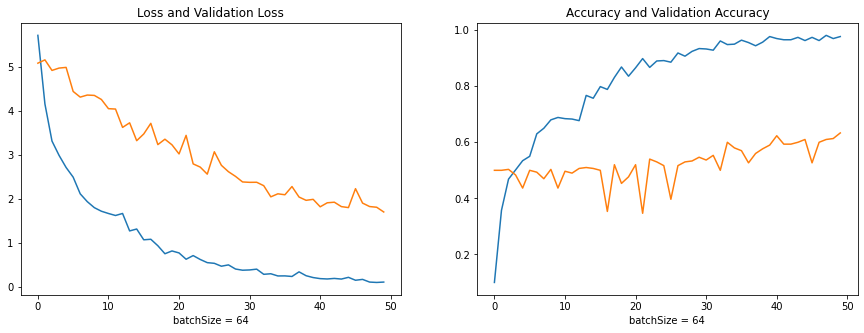 

**Comentarios:** Se puede observar cierta tendencia al alza en la precisión del modelo, que quizás pueda mejorarse entrenando más épocas que las 50 actuales.

&nbsp;

### Ejecución 2: units = 256 última capa densa. batchsSize = 64  epochsSize = 100
batchSize = 64  
Minimum Validation Loss: 1.7399 in epoch 53   
Maximum Validation Accuracy: 0.6667 in epoch 73   

Evaluación del modelo con datos de entrenamiento  
Test loss, Test accuracy: 0.0065935407765209675 &nbsp; 1.0

Evaluación del modelo con datos de validación  
Test loss, Test accuracy: 2.112797498703003 &nbsp; 0.6499999761581421  

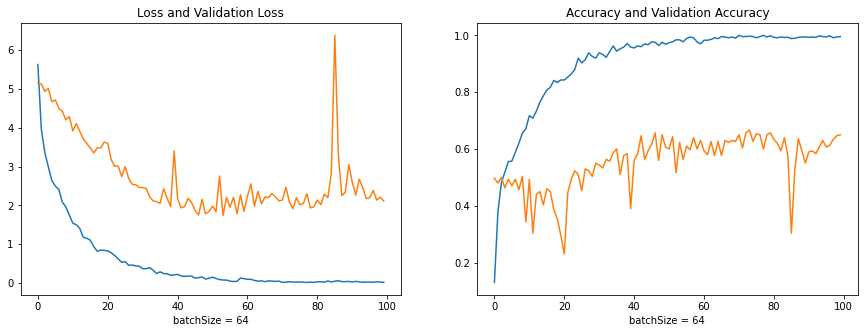  

**Comentarios:** Efectivamente, al aumentar las épocas se ha conseguido mejorar la precisión hasta un 66.7%, aunque la pérdida se ha elevado

&nbsp;

### Ejecución 3: units = 256 última capa densa. / batchsSize = [2, 4, 8, 16, 32, 64, 128] / epochsSize = 100
Best Results:  
Minimum Validation Loss: 1.6887 in epoch 26 with batchSize = 32  
**Maximum Validation Accuracy: 0.6900 in epoch 44 with batchSize = 16  ----> Mejor precisión hasta el momento**

&nbsp;

### Ejecución 4: units = 256 última capa densa. / batchsSize = 16 / epochsSize = 100  
*Esta ejecución se realiza para comprobar el carácter no determinista del proceso pues está basado en el método iterativo Stochastic Gradient Descent*

batchSize = 16  
Minimum Validation Loss: 1.9392 in epoch 53   
Maximum Validation Accuracy: 0.6733 in epoch 78   

Evaluación del modelo con datos de entrenamiento  
Test loss, Test accuracy: 0.072989322245121 &nbsp; 0.9757142663002014  

Evaluación del modelo con datos de validación  
Test loss, Test accuracy: 2.500619888305664 &nbsp; 0.6466666460037231  

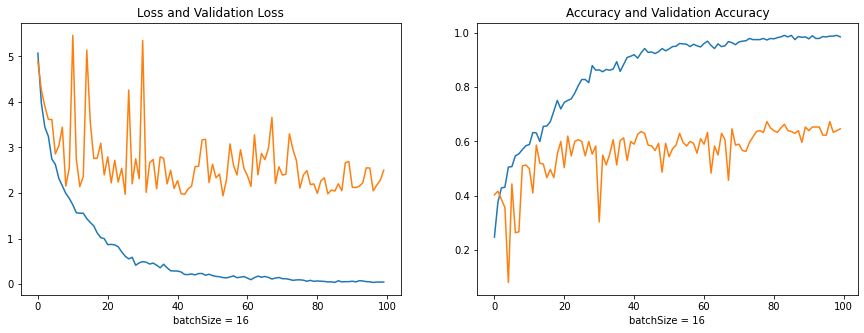

**Comentarios:** No se llega al 69% de precisión conseguido en la ejecución anterior con los mismos hiperparámetros

&nbsp;

### Ejecución 5: units = 256 última capa densa. / batchsSize = 64 / epochsSize = 100 / metrics=['sparse_categorical_accuracy']  
*Se ha cambiado la métrica 'accuracy' por 'sparse_categorical_accuracy'*

batchSize = 64  
Minimum Validation Loss: 1.7709 in epoch 47   
Maximum Validation Accuracy: **0.6833 in epoch 80**   

Evaluación del modelo con datos de entrenamiento  
Test loss, Test accuracy: 0.017007440328598022 0.9971428513526917   

Evaluación del modelo con datos de validación  
Test loss, Test accuracy: 2.0611343383789062 0.6399999856948853  

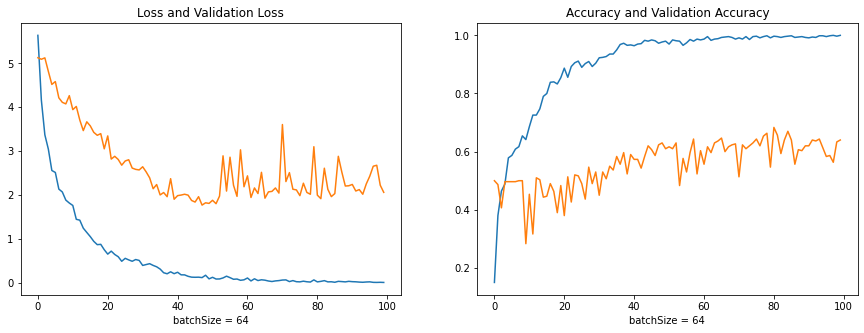  

**Comentarios:** Se obtienen mejores resultados que empleando esta nueva métrica (comparar con Ejecución 2)

&nbsp;

### Ejecución 6: units = n_landmark (81313) última capa densa. / batchsSize = 64 / epochsSize = 100 / metrics=['sparse_categorical_accuracy']  

*Aparece: 'Your notebook tried to allocate more memory than is available. It has restarted.', pero se ha conseguido visualizar:*

batchSize = 64
Minimum Validation Loss: 2.1983 in epoch 61 
Maximum Validation Accuracy: **0.6900 in epoch 83**  


**Comentarios:** Es necesario liberar memoria. Para ello los datos no usados serán eliminados (usando traindf = None).

Volvemosa repetir tras la implementación de esta línea:

batchSize = 64
Minimum Validation Loss: 2.1569 in epoch 52 
Maximum Validation Accuracy: 0.6800 in epoch 69 

**Comentarios:** El programa se ejecuta sin problemas